# Task 1: Sentence decoding

## Importing different Language Models

In [2]:
import sys
import os
import numpy as np

def read_vectors_from_file(filename):
    d = {}
    with open(filename, 'rt') as infile:
        for line in infile:
            word, *rest = line.split()
            try:
                d[word] = np.array(list(map(float, rest)))
            except ValueError:
                #print(f"Error parsing word: {word}")
                continue
    return d


glove = read_vectors_from_file("data/glove.42B.300d.txt")

In [3]:
# import a word2vec model from gensim
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
w2v = gensim.downloader.load('fasttext-wiki-news-subwords-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


## Load the data

In [3]:
# Download and extract the data and learn_decoder.py
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
# !mkdir data
# !wget --header="Host: drive.usercontent.google.com" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7" --header="Accept-Language: en-US,en;q=0.9,he;q=0.8" --header="Cookie: HSID=AHJfxja1o67aaDDKP; SSID=AcFaYUEeiC88MwrF9; APISID=-FXvHmBvJ828Jrpq/AaIp_RI6gKwBAA-zy; SAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-1PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; __Secure-3PAPISID=_psqReiv0O2WdiVv/AhLpZThJtVNAPgAJP; S=billing-ui-v3=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:billing-ui-v3-efe=pX9aAWC8SzxQZfQvQ-0SbCFRz65PPkVY:maestro=dsv3G-owxPD6uTATLH0lBQZNadhFo6ZKJiuB9usoQVU; __Secure-BUCKET=CPgG; SID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx_uObP_F4bCqI8I561ccGMwACgYKAWESARQSFQHGX2Mi5DnhBiJ2gjjbMSP0XJbU5BoVAUF8yKrlBjWMdNOfGnmA7TZzmbWD0076; __Secure-1PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyx2BFINS8lXhFUyAFwuvl8CQACgYKAW4SARQSFQHGX2MiWd6bHkI0JN89-1dFZUbS2hoVAUF8yKpc-H3AD8N6tj-dmFG21SeE0076; __Secure-3PSID=g.a000kggtmVDh8D92rqHe5fiG-bMoXQw7Ld8Tf_C8qHhSE2ZoFUyxJl_TGsCsjeiVN72q3lSCWQACgYKASASARQSFQHGX2MiULluXa7aABDwxgCWjB6IyhoVAUF8yKoy_HHYLCqIFMwNjx-GwYWe0076; __Secure-ENID=20.SE=jyM_w2hA8DW6FvPOh9wudde93a0A9P41Epzo098LV_LyU79-VVcJ9K-vNLrhCLuVzi69CyV4RxlSls8AAT9J8odwIXi_ISVn8Z1U1DH52BC3YiwOwO9LKUsBesCbGx2D6u1XwZ5GIP_PZMo1tkLLJq2VCtcxRP9OtC_QgHNbAD4eyc1TTu1C8XbZLFTOIgb0k9IfM2bMBXeha6t3sJysARZWpDIzs3I8wWZ5JtABB253grtjQyCnxyy9MUgTcYAVaoEGwgVHV4V4lSY6gydFkO2gYxl7JqYloqCq74HahGK54TBlsGZIOTM_KvFAsIidcrPaVOBpH6IGQTPChxy3Tr-GLK7VpBiQ8JW7V0xC8XTN1crEaaZnGFQ6MrjDv8f3hCY0Kg; AEC=AQTF6HwEtUB747fVHMzvOWJV9pmRoGs8Ix8FJ1HTrxbE9NY1dtyro2AvNQ; NID=515=Wdt0NWZqVSh3TtdIfjXCGTCCkj7jaJjt-lkOL3hLD_hPSSMyGxKkVthECwGGFbbxmvfM2iKZ1SkPGDVgLwjghAOrV9Ya7iEJJ0eSXZSfszc0WxRXm3Jy6LxqPEZLmY8v3AIkMX-o8KE5ZRXGEzgv_s9pfgS8bmeiIGT13Iiyw9tPzRZDChGijNbZ0Mp1oF-4YKikOZCyo8Km9wXOgLAC9dbeIqAlTdER97cQ7B5GajyRLH_bFrg0lCVN4tyZEycjihHOu6Eq_V88rswgV7uvzemJ_yk4WbbIWJVm9NCO4tWdDQG8NY3EY57xAJbmIhu260jDftYwzjCnpqJ8C1iCm-FjboF6xJwKJEtLkCXagIcSWxfPGqRWIn5KY72ogAMZTlUZ5RE5F8bH4sFgkt5pW_AalY5mxYPOfZgF-9hcJYsF71rMOic6mqSfvR8iNo-k6_SZ-4o5WkYxbwdLgiaIOiCJHkhIGBoXsm5hh5BHDqlk5ERGnFn5zpqOguNLJFjXT3nhaP1g_a2fFvd0bmZw2A9Y6tBNAC7CbDOmSHSmYmLag0qVcqu286CZh5svuhdM-QPcSCt5u0kPgfWN3KBha0G9L9qCiDIwntvnlVNoUYLBM4je1bhGjO9M2tdH_vteLo4vjm9Cq-4I2A; __Secure-1PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; __Secure-3PSIDTS=sidts-CjIB3EgAEi6AJoaJlu_IOdqmparuSFUne3RqD5YKK5hcqKjRlc0CTp9lSpyH2OoVVoqmlxAA; SIDCC=AKEyXzW7IJ8miV8hX_pqzqqPW7--eMWuWfausspLBoDPlfZDCRZDED56ohpancLYOBPizfUzi1aM; __Secure-1PSIDCC=AKEyXzVGnmSuG07J22njRVFPQ_sk88MgnqtYxJd-M0_9Pz3jdh4GpGPhPOqCMrayTU9SJTW3n54; __Secure-3PSIDCC=AKEyXzVScJYbKdtIImPYKpTRkExsc5UhC5n9Rkk8wNFlMZNW3_xkvWlimAXWaZ4T7kTcJy5AE4I" --header="Connection: keep-alive" "https://drive.usercontent.google.com/download?id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56&export=download&authuser=0&confirm=t&uuid=efeb9ce5-a5c5-453b-938d-6c0ece963f3c&at=APZUnTV18b5mSao0MQ2JbtpefTxr%3A1719665236172" -c -O 'data/files.zip'
# !unzip data/files.zip
# !rm data/files.zip

In [4]:
#Let's load the functions from learn_decoder.py
from learn_decoder import read_matrix, learn_decoder

#and the data
data = read_matrix("data/neuralData_for_EXP1.csv", sep=",", header=True, index_col=True)
glove_vectors = read_matrix("data/vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('data/stimuli_180concepts.txt', dtype=np.dtype('U'))  #The names of the 180 concepts

In [5]:
from tqdm.auto import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/lcc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import sklearn.linear_model
from scipy.stats import pearsonr

def voxel_representativeness(data, vectors) -> np.ndarray:
    """ Given a CxV matrix of C concepts and V voxel activations,
    return a V-dimensional vector of voxel representativeness 
    by the following explanation from the paper:
    We learned ridge regression models (regularization parameter set to 1) to predict 
    each semantic dimension from the imaging data of each voxel and its 26 adjacent 
    neighbors in 3D, in cross-validation within the training set. 
    This yielded predicted values for each semantic dimension, which were
    then correlated with the values in the true semantic vectors. The informativeness
    score for each voxel was the maximum such correlation across dimensions.
    """

    # Splitting the data into 18 folds
    np.random.seed(3)

    n_folds = 18
    n_samples = data.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    folds = np.array_split(indices, n_folds)

    # Initialize a vector to hold the maximum correlation for each voxel
    max_correlation = np.zeros(data.shape[1])

    for test_fold in tqdm(folds, desc="Processing folds", unit="fold"):
        # Create training and test sets
        train_indices = np.setdiff1d(indices, test_fold)
        test_data = data[test_fold, :]
        true_vectors = vectors[test_fold, :]
        train_data = data[train_indices, :]
        train_vectors = vectors[train_indices, :]

        # Iterate over each voxel in the training set
        for v in tqdm(range(train_data.shape[1]), desc="Processing voxels", unit="voxel", leave=False):
            # Get the voxel's data and its 26 neighbors (if available)
            voxel_train_data = train_data[:, v]
            voxel_test_data = test_data[:, v]
            neighbors_train_data = []
            neighbors_test_data = []
            
            # Collect neighboring voxels (this is a simplification, actual neighbors would depend on the 3D structure)
            for n in range(max(0, v-26), min(train_data.shape[1], v+27)):
                if n != v:
                    neighbors_train_data.append(train_data[:, n])
                    neighbors_test_data.append(test_data[:, n])
            
            # Combine voxel data with its neighbors
            combined_train_data = np.column_stack([voxel_train_data] + neighbors_train_data)
            combined_test_data = np.column_stack([voxel_test_data] + neighbors_test_data)

            ridge = sklearn.linear_model.RidgeCV(
                alphas=[1],
                fit_intercept=False
                )
            ridge.fit(combined_train_data, train_vectors)
            encoding = ridge.coef_.T

            # Predict the semantic vectors for the test data
            predicted_vectors = combined_test_data @ encoding
            # Find the correlations between the predicted vectors and the true semantic vectors
            true_vectors = vectors[test_fold, :]

            fold_corr = 0
            # Compute the correlation between the predicted vectors and the true vectors
            for bit in range(predicted_vectors.shape[1]):
                corr, _ = pearsonr(predicted_vectors[:, bit], true_vectors[:, bit])
                if np.isnan(corr):
                    continue
                fold_corr = max(fold_corr, abs(corr))
            max_correlation[v] = max(max_correlation[v], fold_corr)

    return max_correlation

In [29]:
def simpl_voxel_representativeness(data, vectors) -> np.ndarray:
    """ Given a CxV matrix of C concepts and V voxel activations,
    return a V-dimensional vector of voxel representativeness 
    by the following explanation from the paper:
    We learned ridge regression models (regularization parameter set to 1) to predict 
    each semantic dimension from the imaging data of each voxel and its 26 adjacent 
    neighbors in 3D, in cross-validation within the training set. 
    This yielded predicted values for each semantic dimension, which were
    then correlated with the values in the true semantic vectors. The informativeness
    score for each voxel was the maximum such correlation across dimensions.
    """

    # Splitting the data into 18 folds
    np.random.seed(3)

    n_folds = 18
    n_samples = data.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    folds = np.array_split(indices, n_folds)

    # Initialize a vector to hold the maximum correlation for each voxel
    max_correlation = np.zeros(data.shape[1])

    for test_fold in tqdm(folds, desc="Processing folds", unit="fold"):
        # Create training and test sets
        train_indices = np.setdiff1d(indices, test_fold)
        train_data = data[train_indices, :]
        train_vectors = vectors[train_indices, :]

        test_data = data[test_fold, :]
        true_vectors = vectors[test_fold, :]

        ridge = sklearn.linear_model.RidgeCV(
            alphas=[1],
            fit_intercept=False
            )
        ridge.fit(train_data, train_vectors)
        encoding = ridge.coef_.T

        # Predict the semantic vectors for the test data
        predicted_vectors = test_data @ encoding
        # Find the correlations between the predicted vectors and the true semantic vectors
        fold_corr = 0
        # Compute the correlation between the predicted vectors and the true vectors
        for bit in range(predicted_vectors.shape[1]):
            corr, _ = pearsonr(predicted_vectors[:, bit], true_vectors[:, bit])
            if np.isnan(corr):
                continue
            fold_corr += abs(corr)
        fold_corr /= predicted_vectors.shape[1]
        # Update the maximum correlation for each voxel
        for v in range(test_data.shape[1]):
            max_correlation[v] = max(max_correlation[v], fold_corr)

    return max_correlation

In [33]:
# We want to lower the dimensionality of the data to 15000 most informative features
# Because it is unclear which features are most informative, we will use the 15000 features with the highest
# overall average values in absolute value.
def get_top_features(data, n_features=None, metric='mean'):
    """
    Select the top n_features based on the mean absolute value of each feature across all samples.
    :param data: The input data matrix (samples x features).
    :param n_features: The number of top features to select.
    :param metric: The metric to use for feature selection 
    ('mean' or 'var' for variance or 'corr' for maximal correlation, 's_corr' for simple version).
    :return: The reduced data matrix and the indices of the selected features.
    """
    if n_features is None:
        return data, np.arange(data.shape[1])

    if metric not in ['mean', 'var', 'corr', 's_corr']:
        raise ValueError("Metric must be 'mean' or 'var' or 'corr' or 's_corr'")
    if metric == 's_corr':
        representativeness = simpl_voxel_representativeness(data, glove_vectors)
    elif metric == 'corr':
        representativeness = voxel_representativeness(data, glove_vectors)
    elif metric == 'var':
        representativeness = np.var(data, axis=0)
    else:
        representativeness = np.mean(np.abs(data), axis=0)
    top_indices = np.argsort(representativeness)[-n_features:]
    return data[:, top_indices], top_indices

data_reduced, top_indices = get_top_features(data, n_features=50000, metric='s_corr')

Processing folds: 100%|██████████| 18/18 [00:17<00:00,  1.05fold/s]


In [18]:
# creating a matrix of the word2vec vectors and custom glove vectors
word2vec_vectors = np.zeros((len(concepts), 300), dtype=np.float32)
custom_glove_vectors = np.zeros((len(concepts), 300), dtype=np.float32)
for i, concept in enumerate(concepts):
    if concept in w2v:
        word2vec_vectors[i] = w2v[concept]
    else:
        print(f"Warning: '{concept}' not found in Word2Vec model. Defaulting to a zero vector.")
        word2vec_vectors[i] = np.zeros(300, dtype=np.float32)
    if concept in glove:
        custom_glove_vectors[i] = glove[concept]
    else:
        print(f"Warning: '{concept}' not found in custom GloVe model. Defaulting to a zero vector.")
        custom_glove_vectors[i] = np.zeros(300, dtype=np.float32)

In [19]:
print(data.shape)
print(data_reduced.shape)
print(glove_vectors.shape)
print(word2vec_vectors.shape)
print(custom_glove_vectors.shape)
print(concepts.shape)

(180, 185866)
(180, 30000)
(180, 300)
(180, 300)
(180, 300)
(180,)


In [20]:
# splitting the data into 18 folds
np.random.seed(3)

n_folds = 18
n_samples = data.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)
folds = np.array_split(indices, n_folds)
print(folds)

[array([ 25,   3,  82, 177, 156, 132,   6,  86,  70,  58]), array([ 83,  34,  38, 101,   4, 115,  23,  77,  87,  15]), array([168,  71, 161,  47, 120,  98, 171,  42,  40, 143]), array([122,  89,  51,  73,  72, 102,  64, 136, 178,  46]), array([ 17,  41,  31, 153,   5, 164,  92, 173, 174,  12]), array([ 14,  24, 100,  67,   8, 112,  53,  27,  78, 108]), array([144,  43, 128,  57, 162,  22, 151, 145, 109,  63]), array([121, 133, 154,  45,  35,  65,  50, 118, 167,  19]), array([163, 105,  68,  76, 125,  10,  84,  11, 130,  88]), array([159, 111,   9, 103, 158,  29,  39,  56, 175, 165]), array([139,  74,  59, 134,  44, 155, 157,  36, 141, 160]), array([ 52, 135,  61,  48,  30, 146,  13,  95,  96,  55]), array([ 75, 137, 114, 126,  32,  80,  16,  91,  99, 124]), array([140, 117,  85,   1, 113, 170, 116,  18, 176,  54]), array([172,  28, 127,  49,  94,  20,  37,  79, 123,  33]), array([  7,  62, 179,  97, 110, 104,  69,  90, 129,  60]), array([  2,  66, 150,  81,  26, 142,  93, 148, 166, 119

### What are the Accuracy scores?

Define a function that computes rank-based accuracy score, then, iterate over the 18 folds. For each fold,  train the decoder **using the `learn_decoder` function** (the function is already imported from `learn_decoder.py`) on the fold train data, obtain the predicions on the fold test data, and store both the accuracy score of each concept (use the labels from `concepts`) as well as the average score of the 10 concepts.

In [12]:
def test_accuracy(data, folds, embedding_vectors):
    concept_accuracies = {}
    fold_accuracies = []

    for test_id, test_fold in enumerate(folds):
        train_folds = [fold for i, fold in enumerate(folds) if i != test_id]
        train_indices = np.concatenate(train_folds)
        test_indices = test_fold

        train_data = data[train_indices]
        test_data = data[test_indices]

        train_vectors = embedding_vectors[train_indices]
        test_vectors = embedding_vectors[test_indices]

        # Train the decoder
        decoder = learn_decoder(train_data, train_vectors)

        # Get predictions
        predictions = test_data @ decoder

        # Compute accuracy scores
        accuracy_scores = []
        # for each prediction, sorting all vectors by cosine similarity to the prediction
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = test_vectors[i]
            # Compute cosine similarity with all vectors
            similarities = np.dot(embedding_vectors, pred) / (np.linalg.norm(embedding_vectors, axis=1) * np.linalg.norm(pred))
            # Sort by similarity
            sorted_indices = np.argsort(similarities)[::-1]
            # Get the index of the target vector
            target_index = np.where(np.all(embedding_vectors[sorted_indices] == target, axis=1))[0][0] + 1
            accuracy_scores.append(target_index)
            # Store the accuracy score for the concept
            concept_name = concepts[test_indices][i]
            concept_accuracies[concept_name] = target_index
        # Compute the average accuracy score
        avg_accuracy = np.mean(accuracy_scores)
        fold_accuracies.append(avg_accuracy)
    
    return concept_accuracies, fold_accuracies

## Using semantic vectors to decode brain activation (using GloVE)

In [34]:
glove_concept_accuracies, glove_fold_accuracies = test_accuracy(data_reduced, folds, glove_vectors)

Now let's plot the averaged accuracy score for each fold  

Overall average accuracy score: 82.82


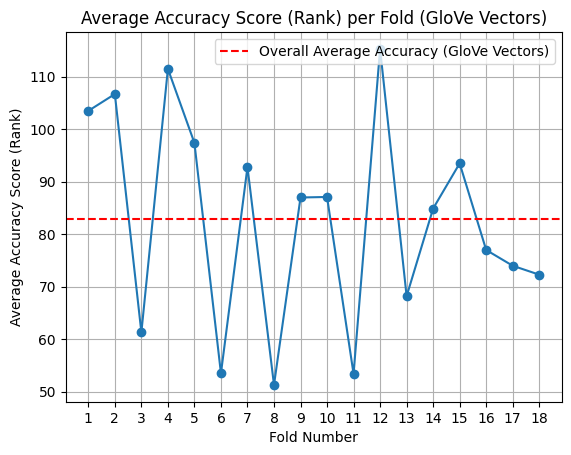

In [35]:
import matplotlib.pyplot as plt

glove_overall_average_accuracy = np.mean(glove_fold_accuracies)
print(f"Overall average accuracy score: {glove_overall_average_accuracy:.2f}")

plt.plot(range(1, n_folds + 1), glove_fold_accuracies, marker='o')
plt.axhline(y=glove_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (GloVe Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (GloVe Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

### Which concepts can be decoded with more or less success?

In [14]:
glove_concept_accuracies = dict(sorted(glove_concept_accuracies.items(), key=lambda item: item[1]))

In [15]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(glove_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: great, Concept Rank: 1.00
Concept: do, Concept Rank: 3.00
Concept: food, Concept Rank: 6.00
Concept: help, Concept Rank: 7.00
Concept: time, Concept Rank: 8.00
Concept: science, Concept Rank: 8.00
Concept: body, Concept Rank: 10.00
Concept: show, Concept Rank: 10.00
Concept: silly, Concept Rank: 12.00
Concept: sound, Concept Rank: 12.00


In [16]:
print("\nThe last 10 concepts are:")
for concept, concept_accuracy in list(glove_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")


The last 10 concepts are:
Concept: election, Concept Rank: 162.00
Concept: usable, Concept Rank: 168.00
Concept: dessert, Concept Rank: 173.00
Concept: sew, Concept Rank: 173.00
Concept: disturb, Concept Rank: 174.00
Concept: electron, Concept Rank: 175.00
Concept: dissolve, Concept Rank: 176.00
Concept: deceive, Concept Rank: 178.00
Concept: cockroach, Concept Rank: 179.00
Concept: argumentatively, Concept Rank: 180.00


### Using semantic vectors to decode brain activation (using custom GloVe)

In [18]:
custom_glove_concept_accuracies, custom_glove_fold_accuracies = test_accuracy(data_reduced, folds, custom_glove_vectors)

Overall average accuracy score (custom GloVe): 80.07


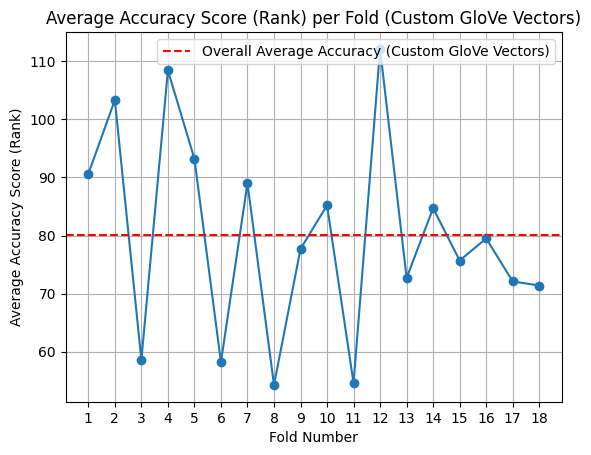

In [19]:
custom_glove_overall_average_accuracy = np.mean(custom_glove_fold_accuracies)
print(f"Overall average accuracy score (custom GloVe): {custom_glove_overall_average_accuracy:.2f}")
plt.plot(range(1, n_folds + 1), custom_glove_fold_accuracies, marker='o')
plt.axhline(y=custom_glove_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Custom GloVe Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (Custom GloVe Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

### Which concepts can be decoded with more or less success?

In [20]:
custom_glove_concept_accuracies = dict(sorted(custom_glove_concept_accuracies.items(), key=lambda item: item[1]))

In [21]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(custom_glove_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: great, Concept Rank: 1.00
Concept: do, Concept Rank: 3.00
Concept: food, Concept Rank: 6.00
Concept: help, Concept Rank: 7.00
Concept: time, Concept Rank: 8.00
Concept: science, Concept Rank: 8.00
Concept: body, Concept Rank: 10.00
Concept: show, Concept Rank: 10.00
Concept: silly, Concept Rank: 12.00
Concept: sound, Concept Rank: 12.00


In [22]:
print("\nThe last 10 concepts are:")
for concept, concept_accuracy in list(custom_glove_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")


The last 10 concepts are:
Concept: election, Concept Rank: 162.00
Concept: usable, Concept Rank: 168.00
Concept: dessert, Concept Rank: 173.00
Concept: sew, Concept Rank: 173.00
Concept: disturb, Concept Rank: 174.00
Concept: electron, Concept Rank: 175.00
Concept: dissolve, Concept Rank: 176.00
Concept: deceive, Concept Rank: 178.00
Concept: cockroach, Concept Rank: 179.00
Concept: argumentatively, Concept Rank: 180.00


### Using semantic vectors to decode brain activation (using Word2Vec)

In [15]:
# Now let's do the same for the word2vec vectors
word2vec_concept_accuracies, word2vec_fold_accuracies = test_accuracy(data_reduced, folds, word2vec_vectors)

Overall average accuracy score (Word2Vec): 86.49


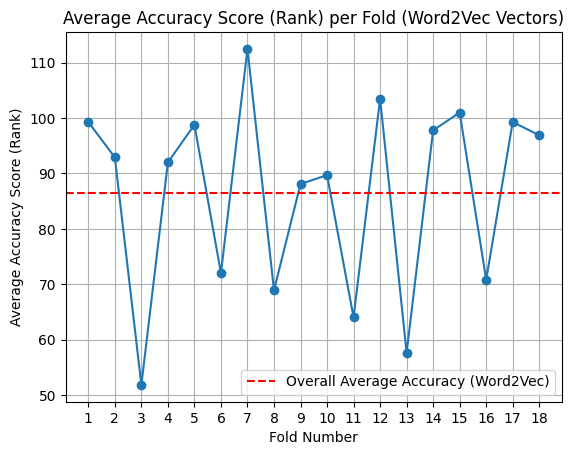

In [16]:
word2vec_overall_average_accuracy = np.mean(word2vec_fold_accuracies)
print(f"Overall average accuracy score (Word2Vec): {word2vec_overall_average_accuracy:.2f}")
plt.plot(range(1, n_folds + 1), word2vec_fold_accuracies, marker='o')
plt.axhline(y=word2vec_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Word2Vec)')
plt.title('Average Accuracy Score (Rank) per Fold (Word2Vec Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

### Which concepts can be decoded with more or less success?

In [25]:
word2vec_concept_accuracies = dict(sorted(word2vec_concept_accuracies.items(), key=lambda item: item[1]))

In [26]:
print("The first 10 concepts are:")
for concept, concept_accuracy in list(word2vec_concept_accuracies.items())[:10]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The first 10 concepts are:
Concept: device, Concept Rank: 4.00
Concept: food, Concept Rank: 4.00
Concept: silly, Concept Rank: 6.00
Concept: great, Concept Rank: 6.00
Concept: ship, Concept Rank: 6.00
Concept: relationship, Concept Rank: 7.00
Concept: garbage, Concept Rank: 9.00
Concept: star, Concept Rank: 9.00
Concept: useless, Concept Rank: 10.00
Concept: land, Concept Rank: 10.00


In [27]:
print("The last 10 concepts are:")
for concept, concept_accuracy in list(word2vec_concept_accuracies.items())[-10:]:
    print(f"Concept: {concept}, Concept Rank: {np.mean(concept_accuracy):.2f}")

The last 10 concepts are:
Concept: electron, Concept Rank: 160.00
Concept: apartment, Concept Rank: 161.00
Concept: election, Concept Rank: 161.00
Concept: dedication, Concept Rank: 164.00
Concept: liar, Concept Rank: 165.00
Concept: pig, Concept Rank: 165.00
Concept: laugh, Concept Rank: 170.00
Concept: emotionally, Concept Rank: 173.00
Concept: deceive, Concept Rank: 176.00
Concept: sew, Concept Rank: 178.00


### Part 1.1

In [28]:
import pickle

In [29]:
with open('data/EXP2.pkl', 'rb') as f: 
	exp2_data = pickle.load(f)
with open('data/EXP3.pkl', 'rb') as f: 
    exp3_data = pickle.load(f)

In [30]:
print(exp2_data['meta'])

[[(array([[88]], dtype=uint8), array([[128]], dtype=uint8), array([[85]], dtype=uint8), array([[ 88, 128,  85]], dtype=uint8), array([[105995],
         [105996],
         [105997],
         ...,
         [883569],
         [883656],
         [883657]], dtype=int32), array([[43, 53, 10],
         [44, 53, 10],
         [45, 53, 10],
         ...,
         [49, 57, 79],
         [48, 58, 79],
         [49, 58, 79]], dtype=uint8), array([[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          

In [31]:
exp2_fmri = exp2_data['Fmridata']
exp2_fmri_reduced = exp2_fmri[:, top_indices]

exp3_fmri = exp3_data['Fmridata']
exp3_fmri_reduced = exp3_fmri[:, top_indices]

In [32]:
print(exp2_fmri.shape)
print(exp2_fmri_reduced.shape)
print(exp3_fmri.shape)
print(exp3_fmri_reduced.shape)

(384, 185866)
(384, 185866)
(243, 185866)
(243, 185866)


In [33]:
# importing the vectors for the seconds and third experiments
exp2_vecs = read_matrix("data/vectors_384sentences.GV42B300.average.txt", sep=" ")
exp3_vecs = read_matrix("data/vectors_243sentences.GV42B300.average.txt", sep=" ")
# importing the corresponding sentences
exp2_sent = np.genfromtxt('data/stimuli_384sentences.txt', delimiter='\t', dtype=np.dtype('U'))
exp3_sent = np.genfromtxt('data/stimuli_243sentences.txt', delimiter='\t', dtype=np.dtype('U'))

In [34]:
print(exp2_vecs.shape)
print(exp3_vecs.shape)
print(exp2_sent.shape)
print(exp3_sent.shape)

(384, 300)
(243, 300)
(384,)
(243,)


In [35]:
def sentence_accuracy(train_data, train_vectors, sentence_data, sentence_vectors):
    sentence_accuracies = {}

    # Train the decoder
    decoder = learn_decoder(train_data, train_vectors)

    # Get predictions
    predictions = sentence_data @ decoder

    # Compute accuracy scores
    accuracy_scores = []
    # for each prediction, sorting all vectors by cosine similarity to the prediction
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        target = sentence_vectors[i]
        # Compute cosine similarity with all vectors
        similarities = np.dot(sentence_vectors, pred) / (np.linalg.norm(sentence_vectors, axis=1) * np.linalg.norm(pred))
        # Sort by similarity
        sorted_indices = np.argsort(similarities)[::-1]
        # Get the index of the target vector
        target_index = np.where(np.all(sentence_vectors[sorted_indices] == target, axis=1))[0][0] + 1
        accuracy_scores.append(target_index)
        # Store the accuracy score for the sentence
        sentence_accuracies[i] = target_index
    # Compute the average accuracy score
    avg_accuracy = np.mean(accuracy_scores)
    
    return sentence_accuracies, avg_accuracy
    

In [37]:
exp2_sentence_accuracies, exp2_avg_accuracy = sentence_accuracy(
    data_reduced, custom_glove_vectors, exp2_fmri_reduced, exp2_vecs)

EXP2 Overall average accuracy score: 156.93 or 40.87% of the maximal rank


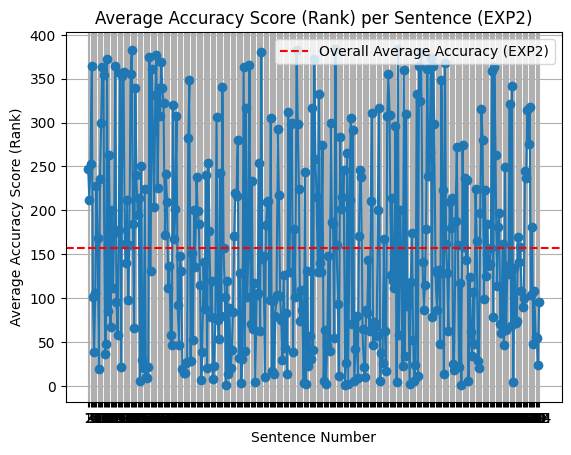

In [38]:
print(f"EXP2 Overall average accuracy score: {exp2_avg_accuracy:.2f} or {exp2_avg_accuracy / len(exp2_sent):.2%} of the maximal rank")
plt.plot(range(1, len(exp2_sentence_accuracies) + 1), list(exp2_sentence_accuracies.values()), marker='o')
plt.axhline(y=exp2_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (EXP2)')
plt.title('Average Accuracy Score (Rank) per Sentence (EXP2)')
plt.xlabel('Sentence Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, len(exp2_sentence_accuracies) + 1))
plt.grid()
plt.legend()
plt.show()

In [39]:
exp3_sentence_accuracies, exp3_avg_accuracy = sentence_accuracy(
    data_reduced, custom_glove_vectors, exp3_fmri_reduced, exp3_vecs)

EXP3 Overall average accuracy score: 100.74 or 41.46% of the maximal rank


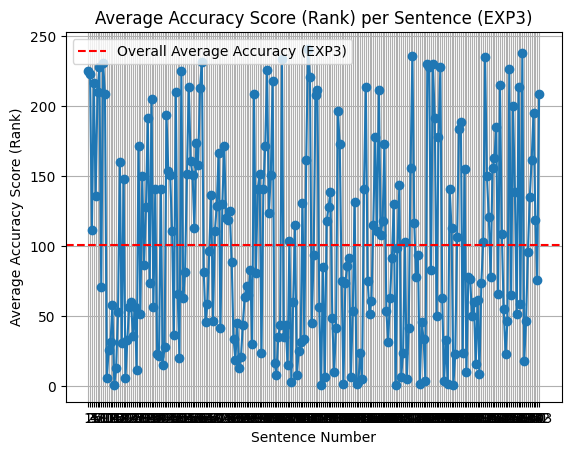

In [40]:
print(f"EXP3 Overall average accuracy score: {exp3_avg_accuracy:.2f} or {exp3_avg_accuracy / len(exp3_sent):.2%} of the maximal rank")
plt.plot(range(1, len(exp3_sentence_accuracies) + 1), list(exp3_sentence_accuracies.values()), marker='o')
plt.axhline(y=exp3_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (EXP3)')
plt.title('Average Accuracy Score (Rank) per Sentence (EXP3)')
plt.xlabel('Sentence Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, len(exp3_sentence_accuracies) + 1))
plt.grid()
plt.legend()
plt.show()

### Part 1.2

In [41]:
# for each sentence, we want to find the category of the sentence
exp2_sentence_to_category = {}
for sentence_id in exp2_sentence_accuracies.keys():
    exp2_sentence_to_category[sentence_id] = exp2_data['keyPassageCategory'].T[exp2_data['labelsPassageCategory'][exp2_data['labelsPassageForEachSentence'][sentence_id]-1]-1][0][0][0][0]

EXP2 Category Average Accuracies:
Category: body_part, Average Accuracy: 70.44 or 18.34% of the maximal rank
Category: human, Average Accuracy: 92.75 or 24.15% of the maximal rank
Category: drink_non_alcoholic, Average Accuracy: 98.94 or 25.76% of the maximal rank
Category: dwelling, Average Accuracy: 113.69 or 29.61% of the maximal rank
Category: appliance, Average Accuracy: 113.75 or 29.62% of the maximal rank
Category: furniture, Average Accuracy: 131.88 or 34.34% of the maximal rank
Category: kitchen_utensil, Average Accuracy: 141.25 or 36.78% of the maximal rank
Category: disaster, Average Accuracy: 149.31 or 38.88% of the maximal rank
Category: fish, Average Accuracy: 152.38 or 39.68% of the maximal rank
Category: tool, Average Accuracy: 153.06 or 39.86% of the maximal rank
Category: bird, Average Accuracy: 156.31 or 40.71% of the maximal rank
Category: place, Average Accuracy: 157.50 or 41.02% of the maximal rank
Category: building_part, Average Accuracy: 158.62 or 41.31% of the

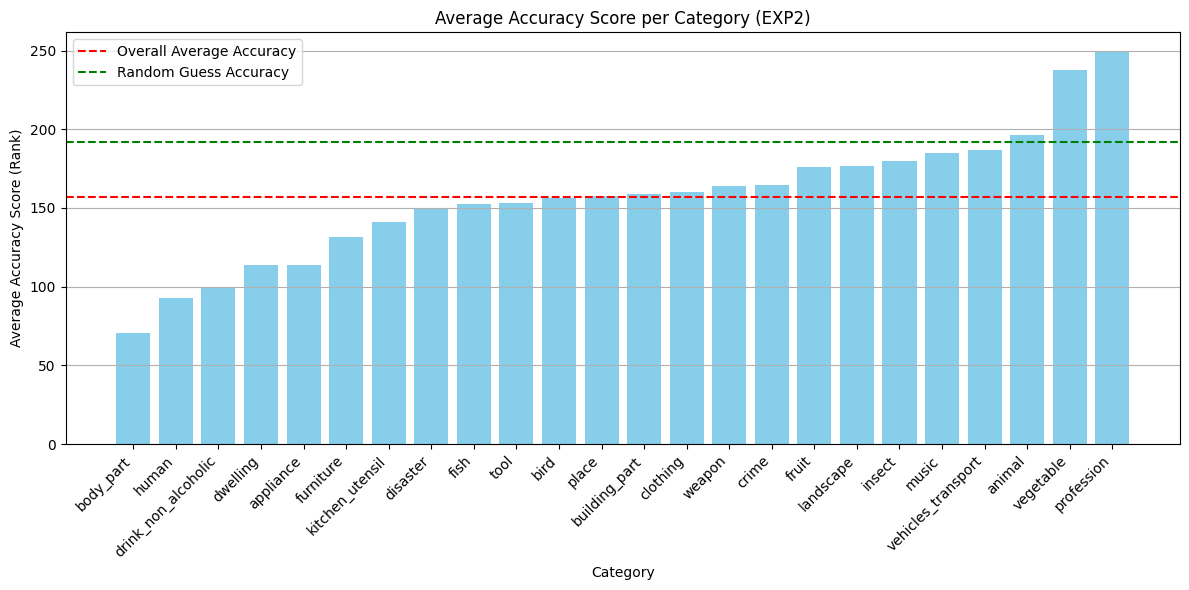

In [42]:
# for each category, we want to find the average accuracy of the sentences in that category
exp2_category_accuracies = {}
for sentence_id, category in exp2_sentence_to_category.items():
    if category not in exp2_category_accuracies:
        exp2_category_accuracies[category] = []
    exp2_category_accuracies[category].append(exp2_sentence_accuracies[sentence_id])
# Calculate the average accuracy for each category
exp2_category_avg_accuracies = {category: np.mean(accuracies) for category, accuracies in exp2_category_accuracies.items()}
# Print the average accuracies sorted by the accuracy value
exp2_category_avg_accuracies = dict(sorted(exp2_category_avg_accuracies.items(), key=lambda item: item[1], reverse=False))
print("EXP2 Category Average Accuracies:")
for category, avg_accuracy in exp2_category_avg_accuracies.items():
    print(f"Category: {category}, Average Accuracy: {avg_accuracy:.2f} or {avg_accuracy / len(exp2_sent):.2%} of the maximal rank")
# Plotting a bar chart of the average accuracies per category
categories = list(exp2_category_avg_accuracies.keys())
avg_accuracies = list(exp2_category_avg_accuracies.values())
plt.figure(figsize=(12, 6))
plt.bar(categories, avg_accuracies, color='skyblue')
# Adding horizontal line for overall average accuracy
overall_avg_accuracy = np.mean(list(exp2_category_avg_accuracies.values()))
plt.axhline(y=overall_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy')
# Adding horizontal line for the random guess accuracy
random_guess_accuracy = len(exp2_sent) / 2
plt.axhline(y=random_guess_accuracy, color='g', linestyle='--', label='Random Guess Accuracy')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Average Accuracy Score (Rank)')
plt.title('Average Accuracy Score per Category (EXP2)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [43]:
exp3_sentence_to_category = {}
for sentence_id in exp3_sentence_accuracies.keys():
    exp3_sentence_to_category[sentence_id] = exp3_data['keyPassageCategory'].T[exp3_data['labelsPassageCategory'][exp3_data['labelsPassageForEachSentence'][sentence_id]-1]-1][0][0][0][0]

EXP3 Category Average Accuracies:
Category: dreams, Average Accuracy: 52.80 or 21.73% of the maximal rank
Category: stress, Average Accuracy: 58.20 or 23.95% of the maximal rank
Category: castle, Average Accuracy: 59.10 or 24.32% of the maximal rank
Category: opera, Average Accuracy: 63.64 or 26.19% of the maximal rank
Category: bone_fracture, Average Accuracy: 68.09 or 28.02% of the maximal rank
Category: law_school, Average Accuracy: 68.20 or 28.07% of the maximal rank
Category: gambling, Average Accuracy: 71.60 or 29.47% of the maximal rank
Category: taste, Average Accuracy: 78.67 or 32.37% of the maximal rank
Category: painter, Average Accuracy: 80.90 or 33.29% of the maximal rank
Category: polar_bear, Average Accuracy: 81.70 or 33.62% of the maximal rank
Category: computer_graphics, Average Accuracy: 89.50 or 36.83% of the maximal rank
Category: hurricane, Average Accuracy: 99.80 or 41.07% of the maximal rank
Category: tuxedo, Average Accuracy: 101.40 or 41.73% of the maximal rank

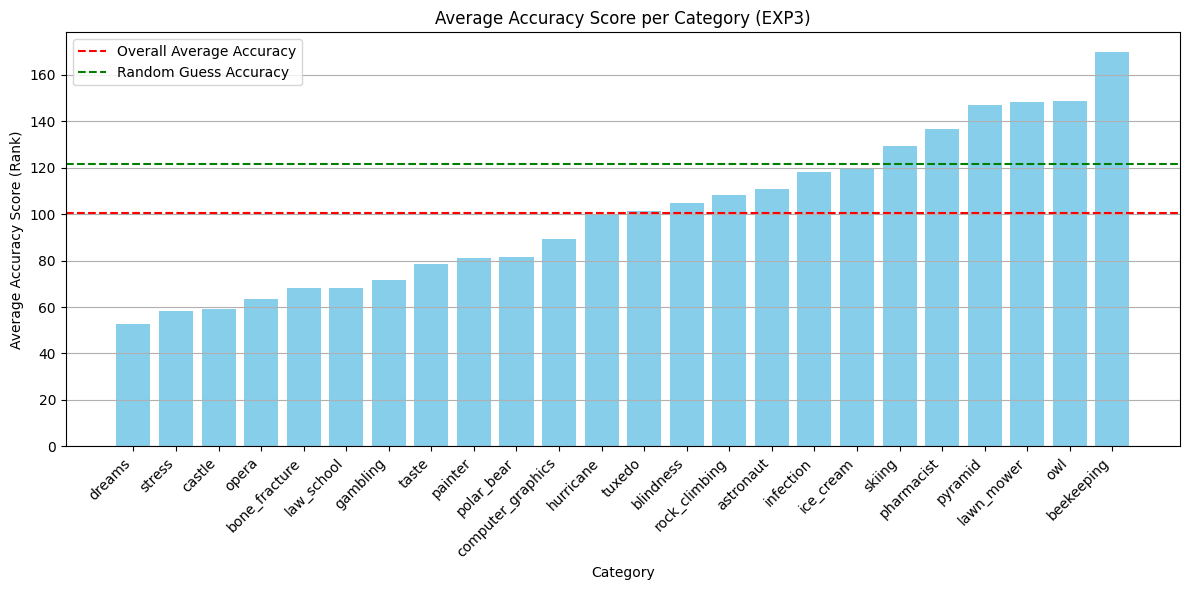

In [44]:
# for each category, we want to find the average accuracy of the sentences in that category
exp3_category_accuracies = {}
for sentence_id, category in exp3_sentence_to_category.items():
    if category not in exp3_category_accuracies:
        exp3_category_accuracies[category] = []
    exp3_category_accuracies[category].append(exp3_sentence_accuracies[sentence_id])
# Calculate the average accuracy for each category
exp3_category_avg_accuracies = {category: np.mean(accuracies) for category, accuracies in exp3_category_accuracies.items()}
# Print the average accuracies sorted by the accuracy value
exp3_category_avg_accuracies = dict(sorted(exp3_category_avg_accuracies.items(), key=lambda item: item[1], reverse=False))
print("EXP3 Category Average Accuracies:")
for category, avg_accuracy in exp3_category_avg_accuracies.items():
    print(f"Category: {category}, Average Accuracy: {avg_accuracy:.2f} or {avg_accuracy / len(exp3_sent):.2%} of the maximal rank")
# Plotting a bar chart of the average accuracies per category
categories = list(exp3_category_avg_accuracies.keys())
avg_accuracies = list(exp3_category_avg_accuracies.values())
plt.figure(figsize=(12, 6))
plt.bar(categories, avg_accuracies, color='skyblue')
# Adding horizontal line for overall average accuracy
overall_avg_accuracy = np.mean(list(exp3_category_avg_accuracies.values()))
plt.axhline(y=overall_avg_accuracy, color='r', linestyle='--', label='Overall Average Accuracy')
# Adding horizontal line for the random guess accuracy
random_guess_accuracy = len(exp3_sent) / 2
plt.axhline(y=random_guess_accuracy, color='g', linestyle='--', label='Random Guess Accuracy')
plt.legend()
plt.xlabel('Category')
plt.ylabel('Average Accuracy Score (Rank)')
plt.title('Average Accuracy Score per Category (EXP3)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Task 2: Sentence representations

In [45]:
import torch
from transformers import BertTokenizer, BertModel
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
test = 'This is a test sentence.'
# Tokenize the input text
inputs = tokenizer(test, return_tensors='pt', padding=True, truncation=True, max_length=512)
# Get the BERT embeddings
with torch.no_grad():
    outputs = model(**inputs)
    # Get the last hidden state
    last_hidden_state = outputs.last_hidden_state
    # Average the token embeddings to get a single vector for the sentence
    sentence_embedding = last_hidden_state.mean(dim=1).squeeze().numpy()

In [46]:
sentence_embedding.shape

(768,)

In [47]:
# We will use sentences from experiment 2 to train and test the decoder
exp2_bert_vecs = np.zeros((len(exp2_sent), 768), dtype=np.float32)
for i, sentence in enumerate(exp2_sent):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        exp2_bert_vecs[i] = last_hidden_state.mean(dim=1).squeeze().numpy()

In [48]:
# splitting the data into 18 folds
np.random.seed(3)

n_folds = 18
n_samples = exp2_fmri_reduced.shape[0]
indices = np.arange(n_samples)
np.random.shuffle(indices)
exp2_folds = np.array_split(indices, n_folds)
print(exp2_folds)

[array([345,  16, 307, 364, 199, 305, 280, 323, 278, 218,  73, 224, 271,
       191, 237, 241,  37,  55, 374, 262,  56, 115]), array([ 15,  40, 189, 214, 332, 102, 301,  24, 201, 228, 348, 321,  81,
       344, 330, 210, 134, 303,  31,  83, 144, 146]), array([261,  66, 142,  61, 243,  98, 313, 128, 107,  27, 306, 105, 353,
       114, 204, 272, 276,  84, 299, 375, 137, 325]), array([250, 379, 127, 130,  82,  53, 333, 239,  10, 126,  74, 188, 194,
       265, 234,  23, 266, 112, 380, 294, 190, 342]), array([ 59,  50,  38, 366, 287, 166,  80, 309, 381,   5,  75,  14,  47,
        46, 123, 154,  79, 193,  30, 376, 367, 329]), array([101, 157, 155,  25, 244,  67, 227, 231, 229,  65, 245, 336, 312,
        70, 269, 103, 310, 136, 185, 370,  68, 153]), array([ 77, 383, 197,  58, 125,  42,   4, 121, 368, 259, 248, 109, 118,
       220,   6, 236, 217, 159, 186, 211, 209]), array([180,   3, 338, 122,  78,  64,  18, 151, 372,  43, 286, 163, 365,
       140, 361, 377, 296, 288, 238, 168, 317]), a

In [49]:
def fold_sentence_accuracy(data, folds, embedding_vectors):
    sentence_accuracies = {}
    fold_accuracies = []

    for test_id, test_fold in enumerate(folds):
        train_folds = [fold for i, fold in enumerate(folds) if i != test_id]
        train_indices = np.concatenate(train_folds)
        test_indices = test_fold

        train_data = data[train_indices]
        test_data = data[test_indices]

        train_vectors = embedding_vectors[train_indices]
        test_vectors = embedding_vectors[test_indices]

        # Train the decoder
        decoder = learn_decoder(train_data, train_vectors)

        # Get predictions
        predictions = test_data @ decoder

        # Compute accuracy scores
        accuracy_scores = []
        # for each prediction, sorting all vectors by cosine similarity to the prediction
        for i in range(predictions.shape[0]):
            pred = predictions[i]
            target = test_vectors[i]
            # Compute cosine similarity with all vectors
            similarities = np.dot(embedding_vectors, pred) / (np.linalg.norm(embedding_vectors, axis=1) * np.linalg.norm(pred))
            # Sort by similarity
            sorted_indices = np.argsort(similarities)[::-1]
            # Get the index of the target vector
            target_index = np.where(np.all(embedding_vectors[sorted_indices] == target, axis=1))[0][0] + 1
            accuracy_scores.append(target_index)
            # Store the accuracy score for the concept
            sentence_id = test_indices[i]
            sentence_accuracies[sentence_id] = target_index
        # Compute the average accuracy score
        avg_accuracy = np.mean(accuracy_scores)
        fold_accuracies.append(avg_accuracy)
    
    return sentence_accuracies, fold_accuracies

In [50]:
# testing the accuracy of the decoder with the original vectors
exp2_org_sentence_accuracies, exp2_org_fold_accuracies = fold_sentence_accuracy(
    exp2_fmri_reduced, exp2_folds, exp2_vecs)
exp2_org_overall_average_accuracy = np.mean(exp2_org_fold_accuracies)

EXP2 Overall average accuracy score (original vectors): 82.64 or 21.52% of the maximal rank


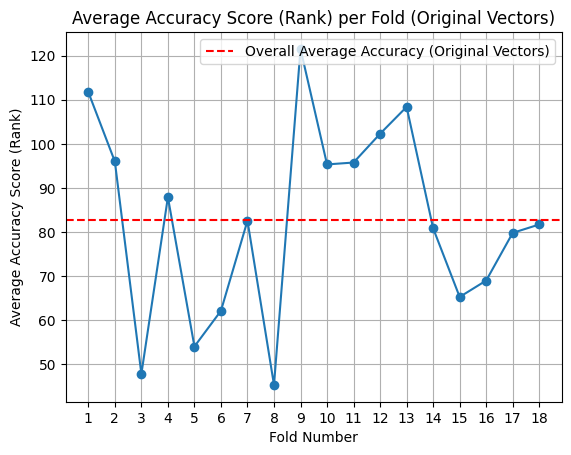

In [51]:
print(f"EXP2 Overall average accuracy score (original vectors): {exp2_org_overall_average_accuracy:.2f} or {exp2_org_overall_average_accuracy / len(exp2_sent):.2%} of the maximal rank")
plt.plot(range(1, n_folds + 1), exp2_org_fold_accuracies, marker='o')
plt.axhline(y=exp2_org_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (Original Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (Original Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

In [52]:
# printing the 

In [53]:
# testing the accuracy of the decoder with BERT vectors
exp2_bert_sentence_accuracies, exp2_bert_fold_accuracies = fold_sentence_accuracy(
    exp2_fmri_reduced, exp2_folds, exp2_bert_vecs)
exp2_bert_overall_average_accuracy = np.mean(exp2_bert_fold_accuracies)

EXP2 Overall average accuracy score (BERT vectors): 48.28 or 12.57% of the maximal rank


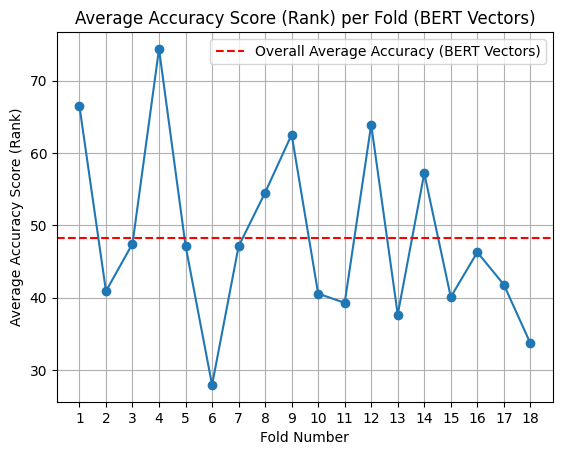

In [54]:
print(f"EXP2 Overall average accuracy score (BERT vectors): {exp2_bert_overall_average_accuracy:.2f} or {exp2_bert_overall_average_accuracy / len(exp2_sent):.2%} of the maximal rank")
plt.plot(range(1, n_folds + 1), exp2_bert_fold_accuracies, marker='o')
plt.axhline(y=exp2_bert_overall_average_accuracy, color='r', linestyle='--', label='Overall Average Accuracy (BERT Vectors)')
plt.title('Average Accuracy Score (Rank) per Fold (BERT Vectors)')
plt.xlabel('Fold Number')
plt.ylabel('Average Accuracy Score (Rank)')
plt.xticks(range(1, n_folds + 1))
plt.grid()
plt.legend()
plt.show()

# Task 3: Brain encoder model

In [58]:
# For each voxel in the dataset corresponding to experiment 2,
# we use the original (and later BERT) vectors, to build a linear regression model for the prediction
# of that voxel's activity.
# For each voxel, we report the R^2 value of the model and the significance of the model.
def voxel_regression(data, vectors):
    """ Given a CxV matrix of C concepts and V voxel activations,
    return a V-dimensional vector of R^2 values for each voxel
    by performing linear regression for each voxel.
    """
    n_voxels = data.shape[1]
    r2_values = np.zeros(n_voxels)
    p_values = np.zeros(n_voxels)

    for v in tqdm(range(n_voxels), desc="Processing voxels", unit="voxel"):
        voxel_data = data[:, v]
        # Fit a linear regression model
        model = sklearn.linear_model.LinearRegression()
        model.fit(vectors, voxel_data)
        
        # Predict the voxel data
        predictions = model.predict(vectors)
        
        # Calculate R^2 value
        r2 = model.score(vectors, voxel_data)
        r2_values[v] = r2
        
        # Calculate p-value using Pearson correlation
        corr, p_value = pearsonr(predictions, voxel_data)
        p_values[v] = p_value   

    return r2_values, p_values

In [57]:
exp2_org_r2_values, exp2_org_p_values = voxel_regression(exp2_fmri_reduced, exp2_vecs)

Processing voxels:   0%|          | 293/185866 [01:02<10:57:28,  4.70voxel/s]

KeyboardInterrupt



In [ ]:
# saving the results to avoid recomputing them
with open('data/exp2_org_r2_values.pkl', 'wb') as f:
    pickle.dump(exp2_org_r2_values, f)
with open('data/exp2_org_p_values.pkl', 'wb') as f:
    pickle.dump(exp2_org_p_values, f)

In [ ]:
# finding how many voxels have a significant R^2 value
significant_voxels = np.sum(exp2_org_p_values < 0.05)
print(f"Number of significant voxels (original vectors): {significant_voxels} out of {exp2_fmri_reduced.shape[1]}")
# plotting the distribution of R^2 values
plt.figure(figsize=(10, 6))
plt.hist(exp2_org_r2_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of R^2 Values for Original Vectors')
plt.xlabel('R^2 Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='R^2 = 0')
plt.axvline(x=np.mean(exp2_org_r2_values), color='green', linestyle='--', label='Mean R^2')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Now we do the same for the BERT vectors
exp2_bert_r2_values, exp2_bert_p_values = voxel_regression(exp2_fmri_reduced, exp2_bert_vecs)

In [ ]:
# Saving the results to avoid recomputing them
with open('data/exp2_bert_r2_values.pkl', 'wb') as f:
    pickle.dump(exp2_bert_r2_values, f)
with open('data/exp2_bert_p_values.pkl', 'wb') as f:
    pickle.dump(exp2_bert_p_values, f)

In [ ]:
# finding how many voxels have a significant R^2 value
significant_voxels_bert = np.sum(exp2_bert_p_values < 0.05)
print(f"Number of significant voxels (BERT vectors): {significant_voxels_bert} out of {exp2_fmri_reduced.shape[1]}")
# plotting the distribution of R^2 values
plt.figure(figsize=(10, 6))
plt.hist(exp2_bert_r2_values, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of R^2 Values for BERT Vectors')
plt.xlabel('R^2 Value')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='R^2 = 0')
plt.axvline(x=np.mean(exp2_bert_r2_values), color='green', linestyle='--', label='Mean R^2')
plt.legend()
plt.grid()
plt.show()